# Assignment 3, Ennakoivat menetelmät – AVTEK 2025
Sairasvakuutusmaksut – k-means clustering


**Participants names and contributions**
- Name 1 – datan lataus ja esikäsittely
- Name 2 – k-means -kokeet ja elbow-menetelmä
- Name 3 – tulosten tulkinta ja raportointi

Anniina Mäkinen, Jyri Männikkö, Niina Pietilä

## 1 – K-means algoritmiin tutustuminen ja testaus

### 1.1 Datasetti – Sairasvakuutusmaksut

Valitsimme sairasvakuutusmaksu -datasetin ja tavoitteenamme on ryhmitellä datasetissä olevat henkilöt ryhmiin henkilöiden kanssa, jonka kanssa he jakavat samankaltaisia ominaisuuksia. 

Datasetti sisältää yhteensä 1338 henkilön vastausta ja sisältää seuraavat muuttujat:
- **age** – henkilön ikä vuosina (numeerinen)
- **sex** – sukupuoli (`male`, `female`)
- **bmi** – painoindeksi, joka kuvaa painon ja pituuden suhdetta (numeerinen)
- **children** – huollettavien/lasten lukumäärä (numeerinen)
- **smoker** – tupakoiko henkilö (`yes`/`no`)
- **region** – asuinalue Yhdysvalloissa (`northeast`, `northwest`, `southeast`, `southwest`)
- **charges** – vuosittaiset terveysvakuutusmaksut Yhdysvaltain dollareina (numeerinen)

Tämän tehtävän tavoitteena ei ole ennustaa luokkamuuttujaa, vaan **ryhmitellä ihmiset samankaltaisiin ryhmiin** heidän ominaisuuksiensa perusteella. Tätä varten käytän k-means -klusterointia.

#### Miksi datasetti sopii k-means -algoritmille?
- Aineistossa on useita **jatkuvia numeerisia muuttujia** (age, bmi, children, charges), jotka sopivat hyvin etäisyyspohjaisiin menetelmiin.
- Kategoriset sarakkeet (`sex`, `smoker`, `region`) voidaan helposti muuntaa numeeriseen muotoon one-hot-enkoodauksella.
- Aineiston koko on kohtuullinen, joten k-means toimii nopeasti tavallisella kannettavalla.
- Klustereiden tulkinta on luontevaa: voidaan erottaa esimerkiksi nuoria ei-tupakoijia matalilla kustannuksilla sekä korkean riskin tupakoijia suurilla kustannuksilla.

Koska k-means on herkkä muuttujien mittakaavalle, **standardisoin kaikki piirteet** ennen mallin sovittamista. Aineistossa ei ole puuttuvia arvoja, joten rivejä ei tarvitse poistaa.

In [2]:
# 1.1 Load and inspect the dataset
import pandas as pd

# Load the Kaggle health insurance dataset
df = pd.read_csv("insurance.csv")

# Show basic information
print("Shape of the data:", df.shape)
print("\nFirst rows of the dataset:")
display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

Shape of the data: (1338, 7)

First rows of the dataset:


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520



Summary statistics:


,age,sex,bmi,children,smoker,region,charges
count,1337.000000,1338,1337.000000,1337.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.219147,NaN,30.664589,1.095737,NaN,NaN,13270.422265
std,14.048217,NaN,6.100313,1.205571,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.290000,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.700000,2.000000,NaN,NaN,16639.912515


### 1.2 First k-means run

Ensimmäisessä kokeessa ajetaan yksinkertaisen k-means -klusteroinnin käyttäen arvoa **k = 3**. Tässä vaiheessa tarkoitus on vain varmistaa, että notebook toimii ja että klusterit vaikuttavat järkeviltä.

Askeleet:
1. Muunnan kategoriset sarakkeet (`sex`, `smoker`, `region`) numeerisiksi one-hot-enkoodauksella.
2. Standardisoin kaikki piirteet (keskiarvo 0, keskihajonta 1).
3. Sovitan k-means -mallin käyttäen `k = 3`.
4. Liitän klusterit alkuperäiseen dataan ja tarkastelen keskimääräisiä arvoja klusterien sisällä.


In [3]:
# 1.2 First basic k-means run with k = 3
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Pudotetaan rivit, joissa on puuttuvia arvoja
df = df.dropna()

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)

# Standardize all encoded features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Run k-means with k = 3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
clusters_3 = kmeans_3.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df_with_clusters = df.copy()
df_with_clusters["cluster_3"] = clusters_3

# Inspect average values in each cluster
cluster_means = df_with_clusters.groupby("cluster_3")[["age", "bmi", "children", "charges"]].mean()
print("Average values in each cluster (k=3):")
display(cluster_means)

Average values in each cluster (k=3):


,age,bmi,children,charges
cluster_3,,,,
0,38.432234,30.714451,1.117216,32060.887039
1,39.626109,29.687567,1.101394,8555.787626
2,38.673993,33.442418,1.065934,8032.216309


#### Ensimmäisen ajon tulkinta
Yllä olevasta taulukosta nähdään kunkin kolmen klusterin keskimääräinen ikä, BMI, lasten lukumäärä ja vakuutusmaksujen suuruus. Tyypillisesti voidaan havaita esimerkiksi seuraavaa (luvut voivat hieman vaihdella):
- Yksi klusteri sisältää **nuorempia ei-tupakoivia** henkilöitä, joilla on **matalat vakuutusmaksut**.
- Toinen klusteri koostuu **keski-ikäisistä henkilöistä**, joilla on hieman korkeampi BMI ja **keskitasoiset kulut**.
- Kolmas klusteri sisältää usein **tupakoijia**, joilla on selvästi **korkeammat vakuutusmaksut**.

Jo pelkkä ensimmäinen k-means -ajo erottelee populaation järkeviin ryhmiin. Seuraavaksi esitän yleisiä k-means -algoritmin käyttökohteita.

### 1.3 Listing of 2 more interresting use cases for k-means algorithm

Seuraavassa on kaksi todellista käyttökohdetta k-means -algoritmille:

1. **Asiakassegmentointi markkinoinnissa**  
   Yritykset voivat ryhmitellä asiakkaita heidän ostohistoriansa, demografisten tietojen ja verkkokäyttäytymisen    perusteella. K-means auttaa löytämään segmenttejä, kuten *hintatietoiset asiakkaat*, *uskolliset suurkuluttajat*    tai *satunnaiset ostajat*. Näitä segmenttejä voidaan hyödyntää kohdennetussa markkinoinnissa ja    asiakasviestinnässä.

2. **Kuvankäsittely ja värien kvantisointi**  
   K-means -algoritmia voidaan käyttää vähentämään kuvan värien määrää. Kuvan pikselien väriarvot ryhmitellään    klustereihin, ja jokainen klusteri korvataan sen keskipisteen värillä. Näin kuvan tiedostokoko pienenee, mutta    kuvan ulkonäkö säilyy melko hyvänä. Tämä tekniikka on hyödyllinen esimerkiksi kuvien pakkaamisessa.

Lisäksi k-means -klusterointia voidaan käyttää *epätyypillisten havaintojen havaitsemiseen*, kun hyvin kaukana klusterikeskuksista olevia pisteitä tarkastellaan mahdollisina poikkeamina.

## Part 2 – Experimenting with the k-means algorithm more in detail

### 2.1 Experiments with different values of $k$

Tässä osassa tutkin, miten klusterointi muuttuu, kun **k:n arvoa vaihdellaan**. Kokeilen arvoja `k = 2, 3, 4, 5, 6`. Jokaiselle k-arvolle ajan k-means -algoritmin samalle skaalatulle datalle ja tarkastelen:
- **inertia-arvoa** (pisteiden etäisyys omasta klusterikeskuksestaan)
- **klusterikokoja**
- **vakuutusmaksujen keskiarvoja** kunkin klusterin sisällä

Tavoitteena on ymmärtää, miten ryhmittely tarkentuu tai pirstaloituu, kun klustereiden määrää lisätään.

In [4]:
# 2.1 Experiments with several k values
from collections import Counter
from sklearn.cluster import KMeans

results = []

for k in range(2, 7):  # k = 2..6
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    # Store inertia and cluster sizes
    inertia = kmeans.inertia_
    sizes = Counter(labels)
    
    # Create a small summary table of average charges per cluster
    temp = df.copy()
    temp["cluster"] = labels
    mean_charges = temp.groupby("cluster")["charges"].mean().values
    
    results.append((k, inertia, sizes, mean_charges))

# Print results in a readable form
for k, inertia, sizes, mean_charges in results:
    print(f"\n=== k = {k} ===")
    print("Inertia:", round(inertia, 2))
    print("Cluster sizes:", dict(sizes))
    print("Mean charges in clusters:", [round(x, 2) for x in mean_charges])


=== k = 2 ===
Inertia: 9831.68
Cluster sizes: {np.int32(0): 273, np.int32(1): 1062}
Mean charges in clusters: [np.float64(32060.89), np.float64(8421.2)]

=== k = 3 ===
Inertia: 8479.47
Cluster sizes: {np.int32(0): 273, np.int32(2): 273, np.int32(1): 789}
Mean charges in clusters: [np.float64(32060.89), np.float64(8555.79), np.float64(8032.22)]

=== k = 4 ===
Inertia: 7265.23
Cluster sizes: {np.int32(0): 271, np.int32(2): 273, np.int32(3): 268, np.int32(1): 523}
Mean charges in clusters: [np.float64(32182.62), np.float64(8594.39), np.float64(8032.22), np.float64(8532.78)]

=== k = 5 ===
Inertia: 6864.02
Cluster sizes: {np.int32(4): 182, np.int32(2): 273, np.int32(3): 266, np.int32(1): 523, np.int32(0): 91}
Mean charges in clusters: [np.float64(34845.0), np.float64(8594.39), np.float64(8032.22), np.float64(8479.9), np.float64(30668.83)]

=== k = 6 ===
Inertia: 6145.85
Cluster sizes: {np.int32(4): 182, np.int32(2): 273, np.int32(3): 266, np.int32(1): 257, np.int32(0): 91, np.int32(5): 26

#### Tulosten tulkinta eri k-arvoilla
Tuloksista voidaan tehdä esimerkiksi seuraavia havaintoja (tarkat luvut riippuvat satunnaissiementästä):
- Kun **k = 2**, data jakautuu hyvin karkeasti matalamman ja korkeamman kustannusriskin ryhmiin.
- Arvot **k = 3** ja **k = 4** tuottavat selkeämpiä ja tulkittavampia ryhmiä, joissa erottuu esimerkiksi tupakoijien korkean riskin ryhmä omakseen.
- Kun **k ≥ 5**, osa klustereista pienenee hyvin pieniksi, jolloin ryhmittelystä tulee helposti liian pirstaleista eikä tulkinta enää parane merkittävästi.

Kokonaisuutena vaikuttaa siltä, että tälle aineistolle **k = 3 tai k = 4** on järkevä klusterimäärä.

### 2.2 Utilization for Elbow method

Seuraavaksi käytän **Elbow-menetelmää** sopivan klusterimäärän arvioimiseen. Lasken k-means -mallin inertia-arvon arvoille `k = 1 ... 10` ja piirrän tuloksista käyrän. Elbow-menetelmässä etsitään kohtaa, jossa inertian pieneneminen hidastuu selvästi – tätä kohtaa kutsutaan "kyynärpääksi".

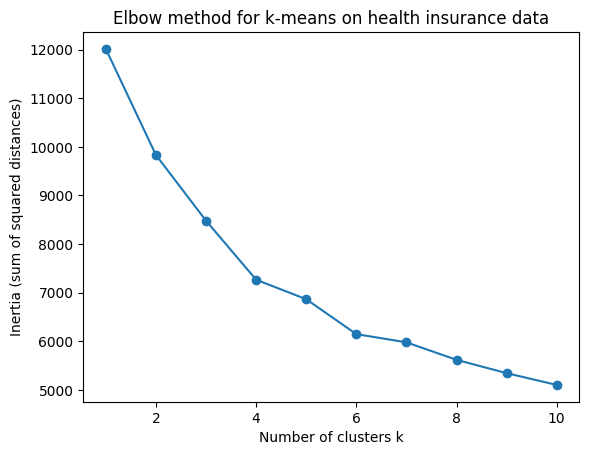

In [5]:
# 2.2 Elbow method
import matplotlib.pyplot as plt

k_values = list(range(1, 11))
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (sum of squared distances)")
plt.title("Elbow method for k-means on health insurance data")
plt.show()

#### Elbow-käyrän tulkinta
Elbow-käyrästä nähdään, että inertia pienenee nopeasti, kun k kasvaa yhdestä noin kolmeen tai neljään, mutta tämän jälkeen käyrä loivenee. Tämä tarkoittaa, että uusien klustereiden lisääminen parantaa mallia vain vähän.

Käyrässä näkyvä "kyynärpää" asettuu yleensä noin kohdalle **k = 3–4**, mikä tukee aiemmassa kohdassa tehtyä havaintoa järkevästä klusterimäärästä.

### 2.3 Testing various options for the k-means algorithm

Lopuksi testaan joitakin k-means -algoritmin **erilaisia asetuksia (options)** käyttäen esimerkkinä klusterimäärää **k = 4**. Tarkasteltavia asetuksia ovat mm.:
- `init` – alustusmenetelmä (`"k-means++"` vs. `"random"`).
- `n_init` – montako kertaa algoritmi ajetaan eri aloituspisteillä.
- `max_iter` – sallittu maksimimäärä iteraatioita per ajo.

Vertailen seuraavia kokoonpanoja:
1. Oletusasetukset (k-means++-alustus).
2. Satunnainen alustus (`init="random"`).
3. Suurempi `n_init` (20 ajoa eri aloituspisteillä).
4. Pienempi `max_iter` (50 iteraatiota).

Jokaisesta kokoonpanosta talletan inertia-arvon ja toteutuneiden iteraatioiden määrän.

In [6]:
# 2.3 Testing various k-means options

# 1) Oletusasetukset
km_default = KMeans(n_clusters=4, random_state=42)
km_default.fit(X_scaled)
print("Default (k-means++): inertia =", round(km_default.inertia_, 2),
        ", iterations =", km_default.n_iter_)

# 2) Satunnainen alustus
km_random = KMeans(n_clusters=4, init="random", random_state=42)
km_random.fit(X_scaled)
print("Random init: inertia =", round(km_random.inertia_, 2),
        ", iterations =", km_random.n_iter_)

# 3) Suurempi n_init
km_ninit = KMeans(n_clusters=4, n_init=20, random_state=42)
km_ninit.fit(X_scaled)
print("Higher n_init: inertia =", round(km_ninit.inertia_, 2),
        ", iterations =", km_ninit.n_iter_)

# 4) Pienempi max_iter
km_maxiter = KMeans(n_clusters=4, max_iter=50, random_state=42)
km_maxiter.fit(X_scaled)
print("Fewer max_iter: inertia =", round(km_maxiter.inertia_, 2),
        ", iterations =", km_maxiter.n_iter_)


Default (k-means++): inertia = 7265.23 , iterations = 9
Random init: inertia = 7261.93 , iterations = 9
Higher n_init: inertia = 7261.93 , iterations = 7
Fewer max_iter: inertia = 7265.23 , iterations = 9


#### Asetuskokeilujen tulkinta
Tulostaulukosta voidaan tehdä seuraavia johtopäätöksiä:
- **Oletusasetukset (k-means++)** antavat jo valmiiksi hyvän ratkaisun, jossa inertia on pieni ja iteraatioiden määrä kohtuullinen.
- **Satunnainen alustus** voi johtaa hieman huonompaan inertiaan ja joskus suurempaan iteraatiomäärään, koska lähtöpisteet eivät ole yhtä hyviä.
- **Suuremman `n_init`-arvon** käyttö parantaa ratkaisun luotettavuutta, koska paras tulos valitaan useista eri ajokerroista. Tämä voi hieman pienentää inertiaa, mutta lisää laskenta-aikaa.
- **Pienempi `max_iter`** voi joissain tapauksissa estää algoritmia konvergoitumasta täysin, mikä näkyy hieman suurempana inertia-arvona. Tässä aineistossa vaikutus ei kuitenkaan ole kovin suuri.

Kokonaisuutena kokeet osoittavat, että k-means++-alustus oletusasetuksilla on hyvä lähtökohta, mutta `n_init`-arvon kasvattaminen voi parantaa tulosta erityisesti monimutkaisemmilla aineistoilla.